# Modelling COVID-19 Hospitalizations in England

**Author:** Eric Daub, Alan Turing Institute

## Introduction

On 28 June, 2021, newly installed Health Secretary Sajid Javid announced that the COVID-19 Vaccine Programme in the UK had severed the link between infection and severe disease, hospitalization, and death (see [here](https://hansard.parliament.uk/Commons/2021-06-28/debates/16849758-096E-4650-B84D-643DF5458417/Covid-19Update) for the speech made to parliament on this topic). Although cases were rising quickly at the time due to the spread of the Delta variant, this was not leading to as strong a rise in hospital admissions and deaths when compared to the earlier waves of the disease.

However, one problem that had cropped up in the COVID-19 pandemic is that exponential rises in cases, combined with some strong inertia in the causal chains that lead from infection to hospital admission, can obscure a crisis situation that can quickly become much, much worse. The delay between infection and hospital admission can last for a few weeks, so it may be that we just have not waited long enough to see the effect of recent cases on the hospital admissions. This story examines a method for analyzing the COVID-19 data in England for 2020-2021 and accounting for uncertainty by applying Bayesian inference to the problem.

## Data

The UK has a [COVID-19 data website](https://coronavirus.data.gov.uk/) with a public API that allows us to examine daily counts for COVID-19 tests, hospital admissions, deaths, and other statistics surrounding the pandemic. We are principally interested in determining how positive tests collected on a particular date lead to hospital admissions some time later. Because testing was not always consistent in the early days of the pandemic, we will focus our analysis on the fall "second wave" starting in July 2021, using test data starting from May 2021. While the May data likely includes a time period where widespread testing was not available, we do this to give our model a fixed window of 60 days to link hospital admissions to tests on any of the previous days in the window to ensure that we fully account for the possibility of a long delay between tests and hospital admission.

Similarly, since the first vaccine doses were given in late December 2020, we cut off our period of analysis for fitting the model at 31 December, 2021, to ensure that we fit the model to a time period where we can be confident that no vaccines had been given. We will use this time period to fit the model parameters, and then make predictions on the current spring wave using the model parameters derived from the fall data.

First, we can look at the COVID test data for England for this time period:

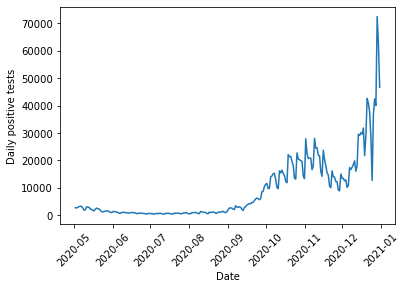

In [4]:
%matplotlib inline

import pandas
import matplotlib.pyplot as plt

def get_data(query_type, start, end):
    "Queries UK Covid Data API for a particular type of data and returns data queried during a specific time frame"
    url = 'https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22query_type%22:%22query_type%22%7D&format=csv'
    new_url = url.replace("query_type", query_type)
    df = pandas.read_csv(new_url)
    df["date"] = pandas.to_datetime(df["date"])
    query_string = 'areaName == "England" & date >= "{}" & date <= "{}"'.format(start, end)
    return df.query(query_string)

cases_str = "newCasesBySpecimenDate"
cases = get_data(cases_str, "2020-05-02", "2020-12-31")

plt.plot(cases["date"], cases[cases_str])
plt.xlabel("Date")
plt.ylabel("Daily positive tests")
plt.xticks(rotation=45);

And for the hospital admissions, we have:

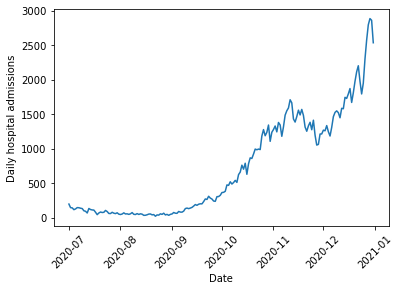

In [5]:
admissions_str = "newAdmissions"
admissions = get_data(admissions_str, "2020-07-01", "2020-12-31")
plt.plot(admissions["date"], admissions[admissions_str])
plt.xlabel("Date")
plt.ylabel("Daily hospital admissions")
plt.xticks(rotation=45);

## Model

We model hospital admissions through the following steps:

1. All positive tests have a fixed probability $\psi$ of causing a hospital admission at some later date.
2. For those that will be admitted to hospital, we use the following model to determine the date:
   1. Every day, a COVID-19 patient that will eventually require hospitalization has a fixed probability $p$ of their condition worsening.
   2. Once their condition has worsened $k$ times, they are admitted to hospital.
   3. This process follows a negative binomial distribution, shifted by $k$ days. An equivalent way to view this is to say that the date of hospital admission follows a multinomial distribution, with the multinomial probabilities following the PMF of a negative binomial distribution, shifted by $k$ days.
   
A negative binomial distribution describes the number of successful Bernoulli trials expected before we obtain a fixed number of failures. Note that we need to shift this distribution because we care about the total number of days before we reach the fixed number of failures, rather than the number of successes.

The model is implemented below. Note that since the UK Covid API returns data with the most recent dates first, while our simulation goes forward in time, we need to reverse the cases to feed it into the function that simulates hospitalizations. Note also that we do a few checks of the admission probabilities before they are fed into the multinomial distribution -- this is because the outputs of the admission probabilities sum to greater than one on occasion due to rounding errors, and sometimes we might have accidentally put in a bad number for $k$ that returns NaN values so we would like to prevent these situations from crashing our simulation.

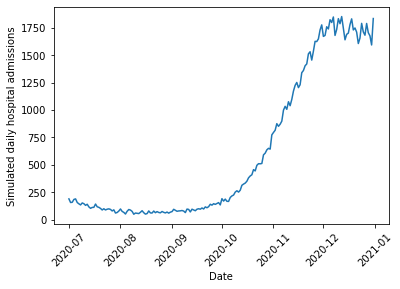

In [6]:
import numpy as np
from scipy.stats import binom, nbinom, multinomial

def reverse_df_data(df, column):
    return np.array(df[column], dtype=np.int64)[::-1]

def simulate_hospital_admissions(cases, psi, k, p):
    "Run a random forward simulation of the hospitalizations given cases and the model parameters"
    
    daily_hospital_admissions = binom.rvs(n=cases, p=np.broadcast_to(psi, (len(cases),)), size=(len(cases),))
    
    window = 60
    dates = np.arange(0, window, 1, dtype=np.int64)
    
    admission_probs = nbinom.pmf(dates, loc=k, n=k, p=p)
    
    # Run a few checks on admission_probs to avoid issues with multinomial sampling
    
    if np.sum(admission_probs) > 1.:
        admission_probs = admission_probs/(1.+1.e-10)
    if np.any(np.isnan(admission_probs)):
        return np.zeros(len(cases)-window, dtype=np.int64)
    
    admissions = np.zeros(len(cases)+window)
    for i in range(len(daily_hospital_admissions)):
        admit_samples = multinomial.rvs(n=daily_hospital_admissions[i], p=admission_probs, size=1)[0]
        admissions[i:i+window] += admit_samples
    
    return admissions[window:-window]

case_array = reverse_df_data(cases, cases_str)
admissions_array = simulate_hospital_admissions(case_array, 0.1, 4, 0.1)

plt.plot(admissions["date"][::-1], admissions_array)
plt.xlabel("Date")
plt.ylabel("Simulated daily hospital admissions")
plt.xticks(rotation=45);

If you try simulating different choices of $\psi$, $k$ and $p$, you can see that the parameters that control the timing of admissions does have an effect on the overall size and shape of the peak (or peaks). Thus, we need to find a way to use the actual hospitalization data to fit reasonable values for these simulation parameters.

## Bayesian Inference

To fit the model and account for uncertainty, we will turn to Bayesian Inference. Bayesian Inference treats our model parameters $\theta = (\psi, p, k)$ as uncertain and thus described by a probability distribution. We wish to compute the posterior distribution of our parameters conditioned on the observed hospitalization data from the fall $y$, written $p(\theta|y)$. To compute this, we use Bayes' rule

$$p(\theta|y)=\frac{p(y|\theta)p(\theta)}{p(y)}$$

which relates the posterior to the likelihood $p(y|\theta)$, or the probability that a given choice of parameters would have produced the data, our prior beliefs about reasonable parameter values $p(\theta)$, and the evidence $p(y)$, which is the probability of getting the data given all possible models. In most cases, computing the evidence is not feasible, so we resort to drawing samples from the posterior distribution rather than computing the distribution analytically.

### Prior

We need to specify our initial beliefs about what we expect might be reasonable model parameters. Based on previous reporting on the pandemic, we expect a relatively small fraction of positive tests to result in hospital admissions. We can quantify this through a Beta distribution, a flexible distribution well suited for modeling parameters that are constrained between 0 and 1. Beta distributions have two shape parameters $a$ and $b$ (or $\alpha$ and $\beta$) that control where the distribution has highest density. We want our priors to be skewed towards small numbers, so we will choose $a=0.5$ and $b=2$, which puts most of the distribution mass at smaller values.

For $k$ and $p$, we might want to consider information that hospital admissions usually occur a week or two after contracting the disease. However, there are two ways our model might express this: $k$ and $p$ could both be large, meaning that the patient has a high probability of their conditions worsening a little bit each day, eventually leading to a (predictable) hospital admission a large number of days later. Alternatively, $p$ and $k$ might both be small. This would describe the situation where the person testing positive has a low chance of their symptoms getting significantly worse every day, but when it does get worse they must be hospitalized quickly. This will lead to more variability in the exact hospitalization date. We have no reason to prefer either possibility, nor would we like to exclude either possibility, so we will use uniform priors for $k$ and $p$ (a Discrete Uniform distribution for $k$ between 1 and 20 and a Beta distribution with $a=1$ and $b=1$ for $p$).

Finally, we should note that the model for determining when a patient goes into hospital is probably not a very realistic description of how a COVID-19 infection proceeds. Rather, we should think more about the two end member cases described above as ways of capturing exactly when, on average, patients need to be admitted to hospital, and the variability in when that occurs. Looking at the values that best fit the data thus tells us more about the type of model that tends to fit the data, rather than providing actual clinical insight into the disease.

### Likelihood

The data for this model is a time series of hospital admissions that is a superposition of many Multinomial distributions. The likelihood for this model unfortunately does not exist in closed form. However, we can easily run a forward simulation of the approach by sampling from the appropriate probability distributions, so we will resort to a method known as Approximate Bayesian Computation (ABC) to approximate the likelihood. Rather than requiring that the forward model produce exactly the same set of hospital admissions as is seen in the data (which is unlikely due to the fact that we are performing a single random sample when we run the forward simulation), we will instead try to find a model that is fairly close to the data and up to some fixed tolerance $\epsilon$ and use a Gaussian measure of dissmilarity between the model and data to allow us to compute an approximate likelihood. We will use $\epsilon=500$ here due to the number of daily hospitalizations being in the thousands at the peak, though some experimenting has shown that the results are not too sensitive to the choice of this parameter.

### Sequential Monte Carlo Sampling

As discussed above, rather than compute the posterior directly, we will draw samples from it. To do so, we will use a technique known as Sequential Monte Carlo (SMC) sampling, or in some contexts as Particle Markov Chain Monte Carlo. SMC is a method for sampling from an unknown distribution (the posterior) by instead sampling from a known distribution (the prior) and then resampling based on weights determined from the computed likelihood $\times$ prior for each sample. The higher the weight of a particular sample, the higher the probability it will be re-sampled and remain in the set of samples taken at the next step. Thus, over time, the samples where the posterior is highest will be repeatedly passed on to the next step, while those where the posterior is lower will be removed.

This resampling technique works best if the two distributions are similar. Because we expect the prior and posterior to be quite different, SMC gradually tunes between the prior and posterior by resampling from $q \propto p(y|\theta)^\beta p(\theta)$ at each step, where $\beta$ varies from 0 to 1. This ensures that the two distributions are reasonably similar at each step and the resampling technique will be accurate.

In addition to resampling, which ensures that good samples are likely to show up in successive steps, SMC also perturbs the samples at each step using a Markov Chain Monte Carlo random walk to ensure that the method explores the regions surrounding good samples. Both the tempering and exploration can be tuned adaptively based on the results of the sampling to try and optimize the number of steps needed to move between the prior and the posterior. This helps to balance accuracy of the sampling with the computational cost.

### Implementation

Below, I implement this model and draw samples from it using the PyMC3 library. The `Simulation` class in PyMC3 allows us to do ABC inference and draw the samples using SMC without having the explicit likelihood implemented in the library.

Note also that I need to bind the array of cases to the simulation function, which I do so using the `partial` function in the `functools` module -- this is because the PyMC3 `Simulation` class requires that the only parameters that are passed to the simulation be the model parameters that we are trying to estimate. Since the actual cases are known, and are not estimated, we need to fix that value of the input.

Finally, PyMC3 by default draws multiple sets of samples based on the number of cores on the computer, so I set the number of chains to be 1 to give consistent results across different machines. Be aware that to draw the full set of 2000 samples, the simulations were run for roughly 10 minutes on a MacBook Pro.

In [7]:
from functools import partial
import pymc3

def fit_model(simulation, cases, hospitalization, epsilon):
    
    simulate_hospital = partial(simulation, cases=cases)

    with pymc3.Model():
        psi = pymc3.Beta("psi", alpha=0.5, beta=2.)
        p = pymc3.Beta("p", alpha=1., beta=1.)
        k = pymc3.DiscreteUniform("k", lower=1, upper=20)
    
        sim_admissions = pymc3.Simulator("admissions", simulate_hospital,
                                         params=(psi, k, p), epsilon=epsilon,
                                         observed=hospitalization)

        trace = pymc3.sample_smc(kernel="ABC", chains=1)

    return trace

obs_array = reverse_df_data(admissions, admissions_str)
epsilon = 500.

trace = fit_model(simulate_hospital_admissions, case_array, obs_array, epsilon)


You can find the C code in this temporary file: /var/folders/p2/kyb6y_1d0pv_vvpdvlcz39h40000gr/T/theano_compilation_error_ipqoo5o2
library imit=] is not found.


Exception: Compilation failed (return status=1): In file included from /Users/clast/.theano/compiledir_Darwin-20.5.0-x86_64-i386-64bit-i386-3.7.11-64/lazylinker_ext/mod.cpp:1:. /Users/clast/opt/anaconda3/envs/TDS/include/python3.7m/Python.h:14:2: error: "Something's broken.  UCHAR_MAX should be defined in limits.h.". #error "Something's broken.  UCHAR_MAX should be defined in limits.h.".  ^. /Users/clast/opt/anaconda3/envs/TDS/include/python3.7m/Python.h:18:2: error: "Python's source code assumes C's unsigned char is an 8-bit type.". #error "Python's source code assumes C's unsigned char is an 8-bit type.".  ^. /Users/clast/opt/anaconda3/envs/TDS/include/python3.7m/Python.h:27:5: error: "Python.h requires that stdio.h define NULL.". #   error "Python.h requires that stdio.h define NULL.".     ^. In file included from /Users/clast/.theano/compiledir_Darwin-20.5.0-x86_64-i386-64bit-i386-3.7.11-64/lazylinker_ext/mod.cpp:1:. In file included from /Users/clast/opt/anaconda3/envs/TDS/include/python3.7m/Python.h:30:. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:73:64: error: use of undeclared identifier 'strchr'. char* __libcpp_strchr(const char* __s, int __c) {return (char*)strchr(__s, __c);}.                                                                ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:80:75: error: use of undeclared identifier 'strpbrk'. char* __libcpp_strpbrk(const char* __s1, const char* __s2) {return (char*)strpbrk(__s1, __s2);}.                                                                           ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:87:65: error: use of undeclared identifier 'strrchr'; did you mean 'strchr'?. char* __libcpp_strrchr(const char* __s, int __c) {return (char*)strrchr(__s, __c);}.                                                                 ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:75:13: note: 'strchr' declared here. const char* strchr(const char* __s, int __c) {return __libcpp_strchr(__s, __c);}.             ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:94:49: error: unknown type name 'size_t'. void* __libcpp_memchr(const void* __s, int __c, size_t __n) {return (void*)memchr(__s, __c, __n);}.                                                 ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:96:46: error: unknown type name 'size_t'. const void* memchr(const void* __s, int __c, size_t __n) {return __libcpp_memchr(__s, __c, __n);}.                                              ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:98:46: error: unknown type name 'size_t'.       void* memchr(      void* __s, int __c, size_t __n) {return __libcpp_memchr(__s, __c, __n);}.                                              ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:101:74: error: use of undeclared identifier 'strstr'; did you mean 'strchr'?. char* __libcpp_strstr(const char* __s1, const char* __s2) {return (char*)strstr(__s1, __s2);}.                                                                          ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:77:13: note: 'strchr' declared here.       char* strchr(      char* __s, int __c) {return __libcpp_strchr(__s, __c);}.             ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:101:74: error: no matching function for call to 'strchr'. char* __libcpp_strstr(const char* __s1, const char* __s2) {return (char*)strstr(__s1, __s2);}.                                                                          ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:77:13: note: candidate disabled: <no message provided>.       char* strchr(      char* __s, int __c) {return __libcpp_strchr(__s, __c);}.             ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:101:81: error: cannot initialize a parameter of type 'char *' with an lvalue of type 'const char *'. char* __libcpp_strstr(const char* __s1, const char* __s2) {return (char*)strstr(__s1, __s2);}.                                                                                 ^~~~. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:77:32: note: passing argument to parameter '__s' here.       char* strchr(      char* __s, int __c) {return __libcpp_strchr(__s, __c);}.                                ^. In file included from /Users/clast/.theano/compiledir_Darwin-20.5.0-x86_64-i386-64bit-i386-3.7.11-64/lazylinker_ext/mod.cpp:1:. In file included from /Users/clast/opt/anaconda3/envs/TDS/include/python3.7m/Python.h:34:. In file included from /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/stdlib.h:100:. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:773:12: error: no member named 'labs' in the global namespace; did you mean 'abs'?.   return ::labs(__x);.          ~~^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:772:39: note: 'abs' declared here. inline _LIBCPP_INLINE_VISIBILITY long abs(long __x) _NOEXCEPT {.                                       ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:777:12: error: no member named 'llabs' in the global namespace.   return ::llabs(__x);.          ~~^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:785:12: error: no member named 'fabsf' in the global namespace.   return ::fabsf(__lcpp_x);.          ~~^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:789:12: error: no member named 'fabs' in the global namespace; did you mean 'abs'?.   return ::fabs(__lcpp_x);.          ~~^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:772:39: note: 'abs' declared here. inline _LIBCPP_INLINE_VISIBILITY long abs(long __x) _NOEXCEPT {.                                       ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:794:12: error: no member named 'fabsl' in the global namespace.   return ::fabsl(__lcpp_x);.          ~~^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:808:34: error: unknown type name 'ldiv_t'. inline _LIBCPP_INLINE_VISIBILITY ldiv_t div(long __x, long __y) _NOEXCEPT {.                                  ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:809:12: error: no member named 'ldiv' in the global namespace.   return ::ldiv(__x, __y);.          ~~^. fatal error: too many errors emitted, stopping now [-ferror-limit=]. 20 errors generated.. 

## Results

### Posterior Distribution

First, we can look at the posterior samples to learn about the type of model that fits the data. We see that $\psi$ has a peak around 9%, meaning that proportion of positive tests lead to hospitalization. The distribution is fairly tight around this value, so there is not much uncertainty in this parameter.

For $p$ and $k$, we see that most of the samples tend to favor the low $p$, low $k$ model described above. As previously discussed, this is not necessarily a realistic model of how an infection evolves, but rather a way of understanding the uncertainty in when a patient goes into hospital. What is important is that there is variability in when we expect positive tests on a given day to lead to later hospitalizations.

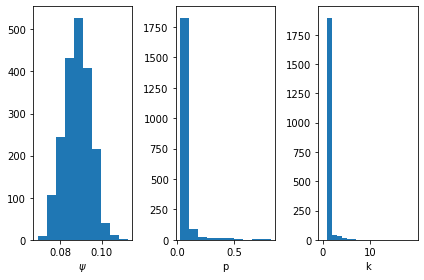

In [5]:
plt.subplot(131)
plt.hist(trace["psi"], bins=10)
plt.xlabel("$\psi$")
plt.subplot(132)
plt.hist(trace["p"], bins=10)
plt.xlabel("p")
plt.subplot(133)
plt.hist(trace["k"], bins=list(range(0, 20)));
plt.xlabel("k")
plt.tight_layout()

### Posterior Predictive Samples

We can look at the range of simulated outcomes and compare these (along with some summary statistics) to the actual evolution in cases.

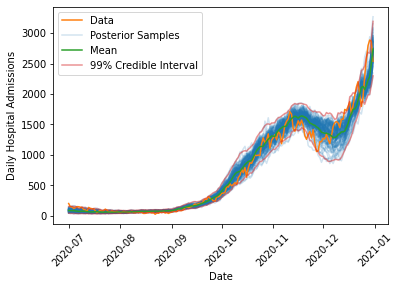

In [6]:
def draw_posterior_samples(cases, trace):
    "Draw samples from the simulation using the SMC samples"

    samples = []

    for s in trace:
        samples.append(simulate_hospital_admissions(cases, s["psi"], s["k"], s["p"]))

    return np.array(samples)

def compute_posterior_statistics(samples):
    "Compute mean and credible intervals from posterior samples"
    
    mean = np.mean(samples, axis=0)
    quantile_005 = np.quantile(samples, 0.005, axis=0)
    quantile_995 = np.quantile(samples, 0.995, axis=0)
    
    return mean, quantile_005, quantile_995

def plot_data_with_samples(cases, admissions, trace):
    
    samples = draw_posterior_samples(cases, trace)
    
    mean, quantile_005, quantile_995 = compute_posterior_statistics(samples)

    plt.plot(admissions["date"][::-1], samples.T[:,:100], color="C0", alpha=0.2)
    plt.plot(admissions["date"], admissions[admissions_str], color="C1", label="Data")
    plt.xlabel("Date")
    plt.ylabel("Daily Hospital Admissions")
    plt.plot([], [], color='C0', alpha=0.2, label='Posterior Samples')
    plt.plot(admissions["date"][::-1], mean, color="C2", label="Mean")
    plt.plot(admissions["date"][::-1], quantile_005, color="C3", alpha=0.5)
    plt.plot(admissions["date"][::-1], quantile_995, color="C3", alpha=0.5, label="99% Credible Interval")
    plt.legend()
    plt.xticks(rotation=45)
    
plot_data_with_samples(case_array, admissions, trace)

The model is able to capture the overall dynamics of the fall wave, including the rise in admissions in October, the decrease in late November due to the second national lockdown, and the continued rise through Christmas. 

Interestingly, the model has difficulty capturing the timing of the decrease at the end of the second lockdown, where the actual data strays outside of the 99% interval on the posterior samples. One reason this might occur is that during the second lockdown, schools remained in session, while most other non-essential sectors of the economy were forced to close. This means that younger children probably saw a smaller decrease in their exposure to COVID than most adults (many of which were just staying home and not going to work), which may have led to more of the positive tests in early November being from a younger population. We expect fewer hospitalizations if a younger population is testing positive, which might explain the more rapid drop in admissions in late November. This appears to be a consistent feature of all models that were fit to the data, suggesting this is a change in the data rather than a shortcoming of the model.

### Predicting the Spring Wave

We can now query the data for the spring increase in cases, and forecast what the model fit on the fall data would predict. We simulate the spring wave for all sets of samples that were drawn from the posterior to determine the posterior predictive distribution, and then for each point in time we can compute credible intervals to put uncertainty bounds on the predicted hospitalizations if the spring wave could be modelled with the same parameters as the fall wave:

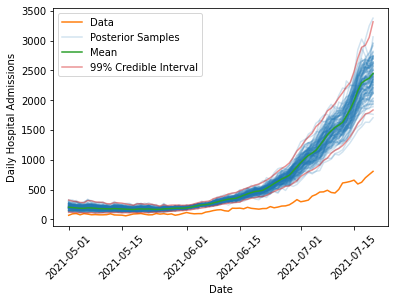

In [7]:
spring_cases = get_data(cases_str, "2021-03-02", "2021-07-20")
spring_case_array = reverse_df_data(spring_cases, cases_str)
spring_admissions = get_data(admissions_str, "2021-05-01", "2021-07-20")

plot_data_with_samples(spring_case_array, spring_admissions, trace)

As we can see, the model predicts substantially more hospitalization (by a factor of 4 or 5), lending credence to the claim that the link between infections and hospital admissions had been weakened. Additionally, the uncertainty in the prediction is much smaller than the observed differences, suggesting that this would need to be due to some extremely rare fluke if there had not been any changes in the data.

## Discussion

Why might the link between infections and hospitalizations be weaker? One obvious reason is vaccination, which is what was highlighted by the Health Secretary in his announcement. While this almost certainly played a big role, we cannot necessarily attribute the entire effect to this. Why?

As mentioned above, we saw that the model had difficulty handling the data during the second national lockdown, and one possible explanation was a change in the population testing positive. Indeed, during the time period under consideration, schools were open while other parts of the economy remained under restriction, meaning that it is possible that more testing in schools could be partially responsible for this difference. As we note above, if this is truly the culprit in the November hospitalization data, the effect is relatively small compared to what we observe here.

Given that we are confident that the data differs from the predictions, how might we account for vaccinations? One possibility is to make $\psi$ no longer a constant, but rather a function of the single and double dose vaccination rates, possibly with a time lag to allow for immunity to build up. We might also fit three different $\psi$ values for 0, 1, or 2 vaccine doses, though since vaccinated people are less likely than unvaccinated people to become infected, we would also need to estimate the chances of infection which is probably more difficult.

Regardless of the exact cause of this reduced hospitalization risk, the change in the data clearly shows that this wave of the pandemic differs from the previous ones. As the government policies become one of learning to live with the virus, rather than actively suppressing it, data on infections and hospitalizations will continue to provide valuable insight into the evolution of the pandemic and should be guiding our decisions and behavior. Hopefully, this model provides an example of how this can be done with an eye for building simple, interpretable models that robustly account for uncertainty.

# Modelling COVID-19 Hospitalizations in England

**Author:** Eric Daub, Alan Turing Institute

## Introduction

On 28 June, 2021, newly installed Health Secretary Sajid Javid announced that the COVID-19 Vaccine Programme in the UK had severed the link between infection and severe disease, hospitalization, and death (see [here](https://hansard.parliament.uk/Commons/2021-06-28/debates/16849758-096E-4650-B84D-643DF5458417/Covid-19Update) for the speech made to parliament on this topic). Although cases were rising quickly at the time due to the spread of the Delta variant, this was not leading to as strong a rise in hospital admissions and deaths when compared to the earlier waves of the disease.

However, one problem that had cropped up in the COVID-19 pandemic is that exponential rises in cases, combined with some strong inertia in the causal chains that lead from infection to hospital admission, can obscure a crisis situation that can quickly become much, much worse. The delay between infection and hospital admission can last for a few weeks, so it may be that we just have not waited long enough to see the effect of recent cases on the hospital admissions. This story examines a method for analyzing the COVID-19 data in England for 2020-2021 and accounting for uncertainty by applying Bayesian inference to the problem.

## Data

The UK has a [COVID-19 data website](https://coronavirus.data.gov.uk/) with a public API that allows us to examine daily counts for COVID-19 tests, hospital admissions, deaths, and other statistics surrounding the pandemic. We are principally interested in determining how positive tests collected on a particular date lead to hospital admissions some time later. Because testing was not always consistent in the early days of the pandemic, we will focus our analysis on the fall "second wave" starting in July 2021, using test data starting from May 2021. While the May data likely includes a time period where widespread testing was not available, we do this to give our model a fixed window of 60 days to link hospital admissions to tests on any of the previous days in the window to ensure that we fully account for the possibility of a long delay between tests and hospital admission.

Similarly, since the first vaccine doses were given in late December 2020, we cut off our period of analysis for fitting the model at 31 December, 2021, to ensure that we fit the model to a time period where we can be confident that no vaccines had been given. We will use this time period to fit the model parameters, and then make predictions on the current spring wave using the model parameters derived from the fall data.

First, we can look at the COVID test data for England for this time period:

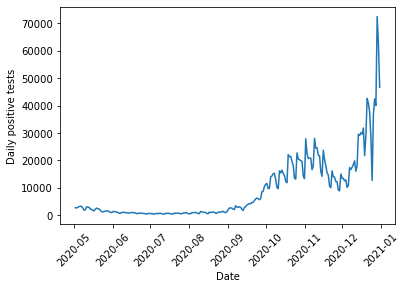

In [4]:
%matplotlib inline

import pandas
import matplotlib.pyplot as plt

def get_data(query_type, start, end):
    "Queries UK Covid Data API for a particular type of data and returns data queried during a specific time frame"
    url = 'https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22query_type%22:%22query_type%22%7D&format=csv'
    new_url = url.replace("query_type", query_type)
    df = pandas.read_csv(new_url)
    df["date"] = pandas.to_datetime(df["date"])
    query_string = 'areaName == "England" & date >= "{}" & date <= "{}"'.format(start, end)
    return df.query(query_string)

cases_str = "newCasesBySpecimenDate"
cases = get_data(cases_str, "2020-05-02", "2020-12-31")

plt.plot(cases["date"], cases[cases_str])
plt.xlabel("Date")
plt.ylabel("Daily positive tests")
plt.xticks(rotation=45);

And for the hospital admissions, we have:

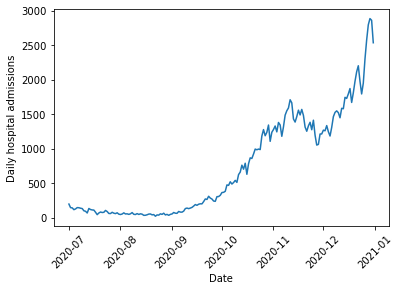

In [5]:
admissions_str = "newAdmissions"
admissions = get_data(admissions_str, "2020-07-01", "2020-12-31")
plt.plot(admissions["date"], admissions[admissions_str])
plt.xlabel("Date")
plt.ylabel("Daily hospital admissions")
plt.xticks(rotation=45);

## Model

We model hospital admissions through the following steps:

1. All positive tests have a fixed probability $\psi$ of causing a hospital admission at some later date.
2. For those that will be admitted to hospital, we use the following model to determine the date:
   1. Every day, a COVID-19 patient that will eventually require hospitalization has a fixed probability $p$ of their condition worsening.
   2. Once their condition has worsened $k$ times, they are admitted to hospital.
   3. This process follows a negative binomial distribution, shifted by $k$ days. An equivalent way to view this is to say that the date of hospital admission follows a multinomial distribution, with the multinomial probabilities following the PMF of a negative binomial distribution, shifted by $k$ days.
   
A negative binomial distribution describes the number of successful Bernoulli trials expected before we obtain a fixed number of failures. Note that we need to shift this distribution because we care about the total number of days before we reach the fixed number of failures, rather than the number of successes.

The model is implemented below. Note that since the UK Covid API returns data with the most recent dates first, while our simulation goes forward in time, we need to reverse the cases to feed it into the function that simulates hospitalizations. Note also that we do a few checks of the admission probabilities before they are fed into the multinomial distribution -- this is because the outputs of the admission probabilities sum to greater than one on occasion due to rounding errors, and sometimes we might have accidentally put in a bad number for $k$ that returns NaN values so we would like to prevent these situations from crashing our simulation.

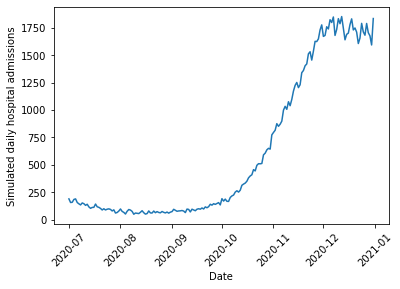

In [6]:
import numpy as np
from scipy.stats import binom, nbinom, multinomial

def reverse_df_data(df, column):
    return np.array(df[column], dtype=np.int64)[::-1]

def simulate_hospital_admissions(cases, psi, k, p):
    "Run a random forward simulation of the hospitalizations given cases and the model parameters"
    
    daily_hospital_admissions = binom.rvs(n=cases, p=np.broadcast_to(psi, (len(cases),)), size=(len(cases),))
    
    window = 60
    dates = np.arange(0, window, 1, dtype=np.int64)
    
    admission_probs = nbinom.pmf(dates, loc=k, n=k, p=p)
    
    # Run a few checks on admission_probs to avoid issues with multinomial sampling
    
    if np.sum(admission_probs) > 1.:
        admission_probs = admission_probs/(1.+1.e-10)
    if np.any(np.isnan(admission_probs)):
        return np.zeros(len(cases)-window, dtype=np.int64)
    
    admissions = np.zeros(len(cases)+window)
    for i in range(len(daily_hospital_admissions)):
        admit_samples = multinomial.rvs(n=daily_hospital_admissions[i], p=admission_probs, size=1)[0]
        admissions[i:i+window] += admit_samples
    
    return admissions[window:-window]

case_array = reverse_df_data(cases, cases_str)
admissions_array = simulate_hospital_admissions(case_array, 0.1, 4, 0.1)

plt.plot(admissions["date"][::-1], admissions_array)
plt.xlabel("Date")
plt.ylabel("Simulated daily hospital admissions")
plt.xticks(rotation=45);

If you try simulating different choices of $\psi$, $k$ and $p$, you can see that the parameters that control the timing of admissions does have an effect on the overall size and shape of the peak (or peaks). Thus, we need to find a way to use the actual hospitalization data to fit reasonable values for these simulation parameters.

## Bayesian Inference

To fit the model and account for uncertainty, we will turn to Bayesian Inference. Bayesian Inference treats our model parameters $\theta = (\psi, p, k)$ as uncertain and thus described by a probability distribution. We wish to compute the posterior distribution of our parameters conditioned on the observed hospitalization data from the fall $y$, written $p(\theta|y)$. To compute this, we use Bayes' rule

$$p(\theta|y)=\frac{p(y|\theta)p(\theta)}{p(y)}$$

which relates the posterior to the likelihood $p(y|\theta)$, or the probability that a given choice of parameters would have produced the data, our prior beliefs about reasonable parameter values $p(\theta)$, and the evidence $p(y)$, which is the probability of getting the data given all possible models. In most cases, computing the evidence is not feasible, so we resort to drawing samples from the posterior distribution rather than computing the distribution analytically.

### Prior

We need to specify our initial beliefs about what we expect might be reasonable model parameters. Based on previous reporting on the pandemic, we expect a relatively small fraction of positive tests to result in hospital admissions. We can quantify this through a Beta distribution, a flexible distribution well suited for modeling parameters that are constrained between 0 and 1. Beta distributions have two shape parameters $a$ and $b$ (or $\alpha$ and $\beta$) that control where the distribution has highest density. We want our priors to be skewed towards small numbers, so we will choose $a=0.5$ and $b=2$, which puts most of the distribution mass at smaller values.

For $k$ and $p$, we might want to consider information that hospital admissions usually occur a week or two after contracting the disease. However, there are two ways our model might express this: $k$ and $p$ could both be large, meaning that the patient has a high probability of their conditions worsening a little bit each day, eventually leading to a (predictable) hospital admission a large number of days later. Alternatively, $p$ and $k$ might both be small. This would describe the situation where the person testing positive has a low chance of their symptoms getting significantly worse every day, but when it does get worse they must be hospitalized quickly. This will lead to more variability in the exact hospitalization date. We have no reason to prefer either possibility, nor would we like to exclude either possibility, so we will use uniform priors for $k$ and $p$ (a Discrete Uniform distribution for $k$ between 1 and 20 and a Beta distribution with $a=1$ and $b=1$ for $p$).

Finally, we should note that the model for determining when a patient goes into hospital is probably not a very realistic description of how a COVID-19 infection proceeds. Rather, we should think more about the two end member cases described above as ways of capturing exactly when, on average, patients need to be admitted to hospital, and the variability in when that occurs. Looking at the values that best fit the data thus tells us more about the type of model that tends to fit the data, rather than providing actual clinical insight into the disease.

### Likelihood

The data for this model is a time series of hospital admissions that is a superposition of many Multinomial distributions. The likelihood for this model unfortunately does not exist in closed form. However, we can easily run a forward simulation of the approach by sampling from the appropriate probability distributions, so we will resort to a method known as Approximate Bayesian Computation (ABC) to approximate the likelihood. Rather than requiring that the forward model produce exactly the same set of hospital admissions as is seen in the data (which is unlikely due to the fact that we are performing a single random sample when we run the forward simulation), we will instead try to find a model that is fairly close to the data and up to some fixed tolerance $\epsilon$ and use a Gaussian measure of dissmilarity between the model and data to allow us to compute an approximate likelihood. We will use $\epsilon=500$ here due to the number of daily hospitalizations being in the thousands at the peak, though some experimenting has shown that the results are not too sensitive to the choice of this parameter.

### Sequential Monte Carlo Sampling

As discussed above, rather than compute the posterior directly, we will draw samples from it. To do so, we will use a technique known as Sequential Monte Carlo (SMC) sampling, or in some contexts as Particle Markov Chain Monte Carlo. SMC is a method for sampling from an unknown distribution (the posterior) by instead sampling from a known distribution (the prior) and then resampling based on weights determined from the computed likelihood $\times$ prior for each sample. The higher the weight of a particular sample, the higher the probability it will be re-sampled and remain in the set of samples taken at the next step. Thus, over time, the samples where the posterior is highest will be repeatedly passed on to the next step, while those where the posterior is lower will be removed.

This resampling technique works best if the two distributions are similar. Because we expect the prior and posterior to be quite different, SMC gradually tunes between the prior and posterior by resampling from $q \propto p(y|\theta)^\beta p(\theta)$ at each step, where $\beta$ varies from 0 to 1. This ensures that the two distributions are reasonably similar at each step and the resampling technique will be accurate.

In addition to resampling, which ensures that good samples are likely to show up in successive steps, SMC also perturbs the samples at each step using a Markov Chain Monte Carlo random walk to ensure that the method explores the regions surrounding good samples. Both the tempering and exploration can be tuned adaptively based on the results of the sampling to try and optimize the number of steps needed to move between the prior and the posterior. This helps to balance accuracy of the sampling with the computational cost.

### Implementation

Below, I implement this model and draw samples from it using the PyMC3 library. The `Simulation` class in PyMC3 allows us to do ABC inference and draw the samples using SMC without having the explicit likelihood implemented in the library.

Note also that I need to bind the array of cases to the simulation function, which I do so using the `partial` function in the `functools` module -- this is because the PyMC3 `Simulation` class requires that the only parameters that are passed to the simulation be the model parameters that we are trying to estimate. Since the actual cases are known, and are not estimated, we need to fix that value of the input.

Finally, PyMC3 by default draws multiple sets of samples based on the number of cores on the computer, so I set the number of chains to be 1 to give consistent results across different machines. Be aware that to draw the full set of 2000 samples, the simulations were run for roughly 10 minutes on a MacBook Pro.

In [7]:
from functools import partial
import pymc3

def fit_model(simulation, cases, hospitalization, epsilon):
    
    simulate_hospital = partial(simulation, cases=cases)

    with pymc3.Model():
        psi = pymc3.Beta("psi", alpha=0.5, beta=2.)
        p = pymc3.Beta("p", alpha=1., beta=1.)
        k = pymc3.DiscreteUniform("k", lower=1, upper=20)
    
        sim_admissions = pymc3.Simulator("admissions", simulate_hospital,
                                         params=(psi, k, p), epsilon=epsilon,
                                         observed=hospitalization)

        trace = pymc3.sample_smc(kernel="ABC", chains=1)

    return trace

obs_array = reverse_df_data(admissions, admissions_str)
epsilon = 500.

trace = fit_model(simulate_hospital_admissions, case_array, obs_array, epsilon)


You can find the C code in this temporary file: /var/folders/p2/kyb6y_1d0pv_vvpdvlcz39h40000gr/T/theano_compilation_error_ipqoo5o2
library imit=] is not found.


Exception: Compilation failed (return status=1): In file included from /Users/clast/.theano/compiledir_Darwin-20.5.0-x86_64-i386-64bit-i386-3.7.11-64/lazylinker_ext/mod.cpp:1:. /Users/clast/opt/anaconda3/envs/TDS/include/python3.7m/Python.h:14:2: error: "Something's broken.  UCHAR_MAX should be defined in limits.h.". #error "Something's broken.  UCHAR_MAX should be defined in limits.h.".  ^. /Users/clast/opt/anaconda3/envs/TDS/include/python3.7m/Python.h:18:2: error: "Python's source code assumes C's unsigned char is an 8-bit type.". #error "Python's source code assumes C's unsigned char is an 8-bit type.".  ^. /Users/clast/opt/anaconda3/envs/TDS/include/python3.7m/Python.h:27:5: error: "Python.h requires that stdio.h define NULL.". #   error "Python.h requires that stdio.h define NULL.".     ^. In file included from /Users/clast/.theano/compiledir_Darwin-20.5.0-x86_64-i386-64bit-i386-3.7.11-64/lazylinker_ext/mod.cpp:1:. In file included from /Users/clast/opt/anaconda3/envs/TDS/include/python3.7m/Python.h:30:. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:73:64: error: use of undeclared identifier 'strchr'. char* __libcpp_strchr(const char* __s, int __c) {return (char*)strchr(__s, __c);}.                                                                ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:80:75: error: use of undeclared identifier 'strpbrk'. char* __libcpp_strpbrk(const char* __s1, const char* __s2) {return (char*)strpbrk(__s1, __s2);}.                                                                           ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:87:65: error: use of undeclared identifier 'strrchr'; did you mean 'strchr'?. char* __libcpp_strrchr(const char* __s, int __c) {return (char*)strrchr(__s, __c);}.                                                                 ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:75:13: note: 'strchr' declared here. const char* strchr(const char* __s, int __c) {return __libcpp_strchr(__s, __c);}.             ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:94:49: error: unknown type name 'size_t'. void* __libcpp_memchr(const void* __s, int __c, size_t __n) {return (void*)memchr(__s, __c, __n);}.                                                 ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:96:46: error: unknown type name 'size_t'. const void* memchr(const void* __s, int __c, size_t __n) {return __libcpp_memchr(__s, __c, __n);}.                                              ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:98:46: error: unknown type name 'size_t'.       void* memchr(      void* __s, int __c, size_t __n) {return __libcpp_memchr(__s, __c, __n);}.                                              ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:101:74: error: use of undeclared identifier 'strstr'; did you mean 'strchr'?. char* __libcpp_strstr(const char* __s1, const char* __s2) {return (char*)strstr(__s1, __s2);}.                                                                          ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:77:13: note: 'strchr' declared here.       char* strchr(      char* __s, int __c) {return __libcpp_strchr(__s, __c);}.             ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:101:74: error: no matching function for call to 'strchr'. char* __libcpp_strstr(const char* __s1, const char* __s2) {return (char*)strstr(__s1, __s2);}.                                                                          ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:77:13: note: candidate disabled: <no message provided>.       char* strchr(      char* __s, int __c) {return __libcpp_strchr(__s, __c);}.             ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:101:81: error: cannot initialize a parameter of type 'char *' with an lvalue of type 'const char *'. char* __libcpp_strstr(const char* __s1, const char* __s2) {return (char*)strstr(__s1, __s2);}.                                                                                 ^~~~. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/string.h:77:32: note: passing argument to parameter '__s' here.       char* strchr(      char* __s, int __c) {return __libcpp_strchr(__s, __c);}.                                ^. In file included from /Users/clast/.theano/compiledir_Darwin-20.5.0-x86_64-i386-64bit-i386-3.7.11-64/lazylinker_ext/mod.cpp:1:. In file included from /Users/clast/opt/anaconda3/envs/TDS/include/python3.7m/Python.h:34:. In file included from /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/stdlib.h:100:. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:773:12: error: no member named 'labs' in the global namespace; did you mean 'abs'?.   return ::labs(__x);.          ~~^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:772:39: note: 'abs' declared here. inline _LIBCPP_INLINE_VISIBILITY long abs(long __x) _NOEXCEPT {.                                       ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:777:12: error: no member named 'llabs' in the global namespace.   return ::llabs(__x);.          ~~^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:785:12: error: no member named 'fabsf' in the global namespace.   return ::fabsf(__lcpp_x);.          ~~^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:789:12: error: no member named 'fabs' in the global namespace; did you mean 'abs'?.   return ::fabs(__lcpp_x);.          ~~^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:772:39: note: 'abs' declared here. inline _LIBCPP_INLINE_VISIBILITY long abs(long __x) _NOEXCEPT {.                                       ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:794:12: error: no member named 'fabsl' in the global namespace.   return ::fabsl(__lcpp_x);.          ~~^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:808:34: error: unknown type name 'ldiv_t'. inline _LIBCPP_INLINE_VISIBILITY ldiv_t div(long __x, long __y) _NOEXCEPT {.                                  ^. /Users/clast/opt/anaconda3/envs/TDS/bin/../include/c++/v1/math.h:809:12: error: no member named 'ldiv' in the global namespace.   return ::ldiv(__x, __y);.          ~~^. fatal error: too many errors emitted, stopping now [-ferror-limit=]. 20 errors generated.. 

## Results

### Posterior Distribution

First, we can look at the posterior samples to learn about the type of model that fits the data. We see that $\psi$ has a peak around 9%, meaning that proportion of positive tests lead to hospitalization. The distribution is fairly tight around this value, so there is not much uncertainty in this parameter.

For $p$ and $k$, we see that most of the samples tend to favor the low $p$, low $k$ model described above. As previously discussed, this is not necessarily a realistic model of how an infection evolves, but rather a way of understanding the uncertainty in when a patient goes into hospital. What is important is that there is variability in when we expect positive tests on a given day to lead to later hospitalizations.

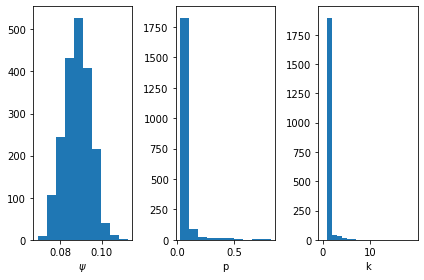

In [5]:
plt.subplot(131)
plt.hist(trace["psi"], bins=10)
plt.xlabel("$\psi$")
plt.subplot(132)
plt.hist(trace["p"], bins=10)
plt.xlabel("p")
plt.subplot(133)
plt.hist(trace["k"], bins=list(range(0, 20)));
plt.xlabel("k")
plt.tight_layout()

### Posterior Predictive Samples

We can look at the range of simulated outcomes and compare these (along with some summary statistics) to the actual evolution in cases.

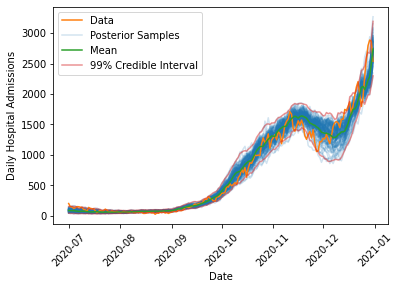

In [6]:
def draw_posterior_samples(cases, trace):
    "Draw samples from the simulation using the SMC samples"

    samples = []

    for s in trace:
        samples.append(simulate_hospital_admissions(cases, s["psi"], s["k"], s["p"]))

    return np.array(samples)

def compute_posterior_statistics(samples):
    "Compute mean and credible intervals from posterior samples"
    
    mean = np.mean(samples, axis=0)
    quantile_005 = np.quantile(samples, 0.005, axis=0)
    quantile_995 = np.quantile(samples, 0.995, axis=0)
    
    return mean, quantile_005, quantile_995

def plot_data_with_samples(cases, admissions, trace):
    
    samples = draw_posterior_samples(cases, trace)
    
    mean, quantile_005, quantile_995 = compute_posterior_statistics(samples)

    plt.plot(admissions["date"][::-1], samples.T[:,:100], color="C0", alpha=0.2)
    plt.plot(admissions["date"], admissions[admissions_str], color="C1", label="Data")
    plt.xlabel("Date")
    plt.ylabel("Daily Hospital Admissions")
    plt.plot([], [], color='C0', alpha=0.2, label='Posterior Samples')
    plt.plot(admissions["date"][::-1], mean, color="C2", label="Mean")
    plt.plot(admissions["date"][::-1], quantile_005, color="C3", alpha=0.5)
    plt.plot(admissions["date"][::-1], quantile_995, color="C3", alpha=0.5, label="99% Credible Interval")
    plt.legend()
    plt.xticks(rotation=45)
    
plot_data_with_samples(case_array, admissions, trace)

The model is able to capture the overall dynamics of the fall wave, including the rise in admissions in October, the decrease in late November due to the second national lockdown, and the continued rise through Christmas. 

Interestingly, the model has difficulty capturing the timing of the decrease at the end of the second lockdown, where the actual data strays outside of the 99% interval on the posterior samples. One reason this might occur is that during the second lockdown, schools remained in session, while most other non-essential sectors of the economy were forced to close. This means that younger children probably saw a smaller decrease in their exposure to COVID than most adults (many of which were just staying home and not going to work), which may have led to more of the positive tests in early November being from a younger population. We expect fewer hospitalizations if a younger population is testing positive, which might explain the more rapid drop in admissions in late November. This appears to be a consistent feature of all models that were fit to the data, suggesting this is a change in the data rather than a shortcoming of the model.

### Predicting the Spring Wave

We can now query the data for the spring increase in cases, and forecast what the model fit on the fall data would predict. We simulate the spring wave for all sets of samples that were drawn from the posterior to determine the posterior predictive distribution, and then for each point in time we can compute credible intervals to put uncertainty bounds on the predicted hospitalizations if the spring wave could be modelled with the same parameters as the fall wave:

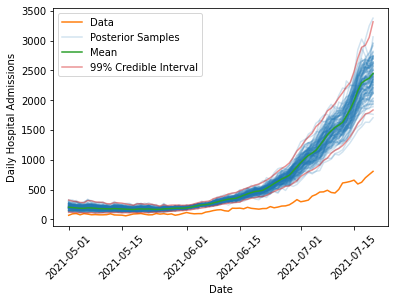

In [7]:
spring_cases = get_data(cases_str, "2021-03-02", "2021-07-20")
spring_case_array = reverse_df_data(spring_cases, cases_str)
spring_admissions = get_data(admissions_str, "2021-05-01", "2021-07-20")

plot_data_with_samples(spring_case_array, spring_admissions, trace)

As we can see, the model predicts substantially more hospitalization (by a factor of 4 or 5), lending credence to the claim that the link between infections and hospital admissions had been weakened. Additionally, the uncertainty in the prediction is much smaller than the observed differences, suggesting that this would need to be due to some extremely rare fluke if there had not been any changes in the data.

## Discussion

Why might the link between infections and hospitalizations be weaker? One obvious reason is vaccination, which is what was highlighted by the Health Secretary in his announcement. While this almost certainly played a big role, we cannot necessarily attribute the entire effect to this. Why?

As mentioned above, we saw that the model had difficulty handling the data during the second national lockdown, and one possible explanation was a change in the population testing positive. Indeed, during the time period under consideration, schools were open while other parts of the economy remained under restriction, meaning that it is possible that more testing in schools could be partially responsible for this difference. As we note above, if this is truly the culprit in the November hospitalization data, the effect is relatively small compared to what we observe here.

Given that we are confident that the data differs from the predictions, how might we account for vaccinations? One possibility is to make $\psi$ no longer a constant, but rather a function of the single and double dose vaccination rates, possibly with a time lag to allow for immunity to build up. We might also fit three different $\psi$ values for 0, 1, or 2 vaccine doses, though since vaccinated people are less likely than unvaccinated people to become infected, we would also need to estimate the chances of infection which is probably more difficult.

Regardless of the exact cause of this reduced hospitalization risk, the change in the data clearly shows that this wave of the pandemic differs from the previous ones. As the government policies become one of learning to live with the virus, rather than actively suppressing it, data on infections and hospitalizations will continue to provide valuable insight into the evolution of the pandemic and should be guiding our decisions and behavior. Hopefully, this model provides an example of how this can be done with an eye for building simple, interpretable models that robustly account for uncertainty.

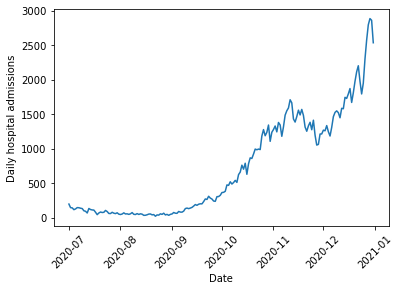

In [2]:
admissions_str = "newAdmissions"
admissions = get_data(admissions_str, "2020-07-01", "2020-12-31")
plt.plot(admissions["date"], admissions[admissions_str])
plt.xlabel("Date")
plt.ylabel("Daily hospital admissions")
plt.xticks(rotation=45);